# datapreprocessing.py

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
dataset = fetch_openml('mnist_784', parser = 'auto')

In [2]:
dataset.data

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
import numpy as np
import torch

X = torch.tensor(dataset.data.to_numpy(np.float32))
y = torch.tensor(dataset.target.to_numpy(np.int64))

In [4]:
n_train = len(dataset.data)
n_pixels = len(dataset.data.columns)
n_classes = len(set(dataset.target))


print(f'Number of training samples : {n_train}')
print(f'Number of training pixels : {n_pixels}')
print(f'Number of training classes : {n_classes}')

Number of training samples : 70000
Number of training pixels : 784
Number of training classes : 10


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(dataset.data, dataset.target, test_size = 0.2 , random_state = 42, stratify = y)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2 , random_state = 42 ,stratify = y_train )

In [6]:
print(f'Number of train X : {X_train.shape}')
print(f'Number of train y : {y_train.shape}')

print()

print(f'Number of valid X : {X_valid.shape}')
print(f'Number of valid y : {y_valid.shape}')

print()

print(f'Number of test X : {X_test.shape}')
print(f'Number of test y : {y_test.shape}')

Number of train X : (44800, 784)
Number of train y : (44800,)

Number of valid X : (14000, 784)
Number of valid y : (14000,)

Number of test X : (11200, 784)
Number of test y : (11200,)


In [7]:
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
    def __init__(self, X , y , transform = None):
        self.X = X.values.reshape((-1,28,28)).astype(np.float32)[:,:,:,None]
        self.y = torch.from_numpy(y.to_numpy(dtype=np.uint64))

        self.transform = transform

        print(self.X.shape)
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [8]:
from torchvision import transforms 

train_transforms = transforms.Compose(
     [transforms.ToTensor(),
     transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2)),
     transforms.Normalize(mean=(0.5,), std=(0.5,))])

val_test_transforms = transforms.Compose(
     [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,))])

# data_visualization.py

In [9]:
import matplotlib.pyplot as plt
import numpy as np

from torchvision.utils import make_grid

(-0.5, 241.5, 31.5, -0.5)

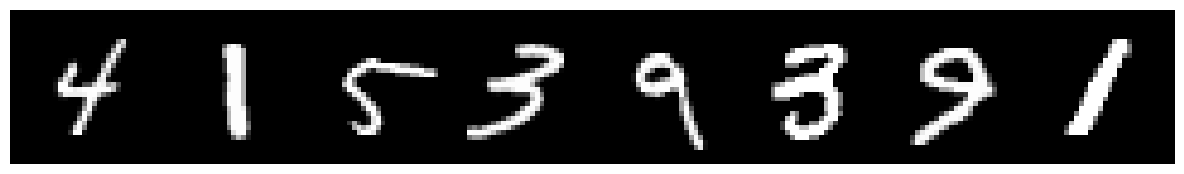

In [10]:
n_train = len(X_train)

random_sel = np.random.randint(n_train, size = 8)
# torch.Tensor(X_train.iloc[random_sel, :].values)
grid = make_grid(torch.Tensor((X_train.iloc[random_sel, :].values/255.)).reshape((-1,28,28)).unsqueeze(1) , nrow = 8)

plt.figure(figsize=(16,2))
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
 

# model.py

In [11]:
import torch
from torch import nn
from tqdm import tqdm

class CNN(nn.Module):
    def __init__(self, input_size , num_class):
        """
        input_size = (1,28,28)
        num_classes = 10
        """

        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(input_size[0], 32, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.fc1 = nn.Linear(4*4*64 , num_class)


    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return x

# trainer.py

In [12]:
import torch

model = CNN((1,28,28), 10)
print(model)
opts = {
    'lr' : 1e-3,
    'epochs' : 20,
    'batch_size' : 64
}

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)


In [13]:
optimizer = torch.optim.Adam(model.parameters(), opts['lr'])
criterion = torch.nn.CrossEntropyLoss()

In [14]:
train_dataset = MNISTDataset(X_train, y_train, transform = train_transforms)
valid_dataset = MNISTDataset(X_valid, y_valid, transform = val_test_transforms)

(44800, 28, 28, 1)
(14000, 28, 28, 1)


In [15]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = opts['batch_size'], shuffle = True)
valid_loader = torch.utils.data.DataLoader(dataset = valid_dataset, batch_size = opts['batch_size'], shuffle = True)

In [19]:
# device = 'mps' if torch.backends.mps.is_available() else 'cpu'

device = 'cpu'
model.to(device)

for epoch in range(opts['epochs']):
    model.train()
    train_loss = []
    for i , (data, labels) in tqdm(enumerate(train_loader) , total = len(train_loader)):
        data.to(device)
        labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    test_loss = []
    test_accuracy = []

    for i , (data, labels) in enumerate(valid_loader):
        data.to(device)
        labels.to(device)
        outputs = model(data)
        _, pred = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        test_loss.append(loss.item())
        test_accuracy.append((pred == labels).sum().item() / pred.size(0))
    
    print('epoch: {}, train loss: {}, test loss: {}, test accuracy: {}'.format(epoch, np.mean(train_loss), np.mean(test_loss), np.mean(test_accuracy)))

 37%|███▋      | 256/700 [00:09<00:16, 26.51it/s]


KeyboardInterrupt: 